## Step 1
Imports and initialisation of a LJ calculator

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import ase, ase.io
from ase.visualize import view
from ase.optimize import BFGS
from ase.calculators.lj import LennardJones
lj_calc = LennardJones(sigma=1.0, epsilon=1.0, rc=12.0)

## Step 2
Initialisation of the simulation box. Parameters:
- 19 LJ atoms, I've chosen He
- Simulation box, side length is 12 - will adjust and justify with research
- Initialisation of positions, random within the box - will adjust and justify with research

### Simulation Box Length
Chosen 12 as suggested in assignment details

### Initial positions
When randomised across the entire box space, particles are so spaced out that instead of forming one 19-atom cluster, they form mini-clusters (typically 2 - 6 atoms, e.g. see trig-bipyramidal and tetrahedral structures attached). 

The reason for this is that the atoms are so far apart that they are not included in the calculation due to the cut-off (set at 4 Å). Even if the cut-off is increased to the size of the simulation box, the force between particles is so low that they will rarely converge.

So instead of randomising the particles across the entire simulation box, restrict the random space to a theoretical box in the centre of the simulation box that is half the size of entire simulation box.

In [48]:
n = 19 # number of LJ atoms
box_length = 12 # length of box side

def initialise_structure(n, box_length):
    
    cell = np.eye(3)*box_length # 3x3 matrix with 
    atoms = ase.Atoms(pbc=True, cell = cell)
    for i in range(n):
        #pos = np.random.rand(3)*cell[1,1] ## randomising positions across the entire simulation box -- doesn't yield desired structure as discussed in the above markdown cell
        pos = np.random.uniform(box_length*0.25, box_length*0.75, size = 3) # generates cartesian coordinates in the center of the simulation box 
        atoms.append(ase.Atom('He', position = pos))

    return atoms

lj_19 = initialise_structure(19, 12)

In [45]:
view(lj_19, viewer='x3d')

## Step 3

Test minimisation to determine parameters `fmax` and `steps` for an appropriate level of convergence.

Through various trials, the energy value (given to 6 decimal places here) doesn't fluctuate much (or at all) below `fmax = 0.001`, thus this seems a reasonable cutoff for a minima such that computation isn't "wasted"

However, I will come back to this, because instpecting fmax across the steps reveals that after 1024 the given trajectory isn't necessarily the lowest energy explored. There should be a way extract the position of the atoms at the lowest energy explored across the 1024 steps if it doesn't converge below `fmax = 0.001`

In [ ]:
def minimise_structure(atoms, f_max=0.001, steps = 1024, id = "test"):
    atoms.calc = lj_calc
    dyn = BFGS(atoms=atoms, trajectory=f'./trajectories/{atoms.symbols}_{id}.traj') # set up BFGS minimiser for the desired Atoms object
    dyn.run(fmax=f_max,steps=steps) # perform minimisation

minimise_structure(lj_19)

      Step     Time          Energy          fmax
BFGS:    0 12:30:03      -62.948752        0.000685


In [47]:
view(lj_19, viewer='x3d')

## Step 4

Performing 100 minimisation cycles starting from a randomised inital structure each time. Generates a database of minim

In [59]:
n = 19 # number of LJ atoms
box_length = 12 # length of box side

energies = []
structures = []

for i in range(100):
    lj_19 = initialise_structure(n = n, box_length = box_length)
    minimise_structure(lj_19, id = i)

    energy = lj_19.get_potential_energy()
    energies.append(energy)
    structures.append(lj_19)

      Step     Time          Energy          fmax
BFGS:    0 14:03:09      442.981108     8406.101240
BFGS:    1 14:03:09       -4.886588        5.025001
BFGS:    2 14:03:09       -5.181653        4.990477
BFGS:    3 14:03:09       -5.767874        4.916567
BFGS:    4 14:03:09        0.534913      135.974267
BFGS:    5 14:03:09       -7.011812        4.780254
BFGS:    6 14:03:09       -6.581480       23.813694
BFGS:    7 14:03:09       -8.028027        4.652605
BFGS:    8 14:03:09       -8.168580        8.633556
BFGS:    9 14:03:09       -8.445056        4.554421
BFGS:   10 14:03:09       -8.634204        4.510219
BFGS:   11 14:03:09       -8.148646       26.014798
BFGS:   12 14:03:09       -8.808267        4.426321
BFGS:   13 14:03:09       -8.967516        4.367765
BFGS:   14 14:03:09       -9.361152       13.407746
BFGS:   15 14:03:09       -9.528074        4.144981
BFGS:   16 14:03:09      -10.013111        3.987467
BFGS:   17 14:03:09       -3.873002      124.903464
BFGS:   18 14:

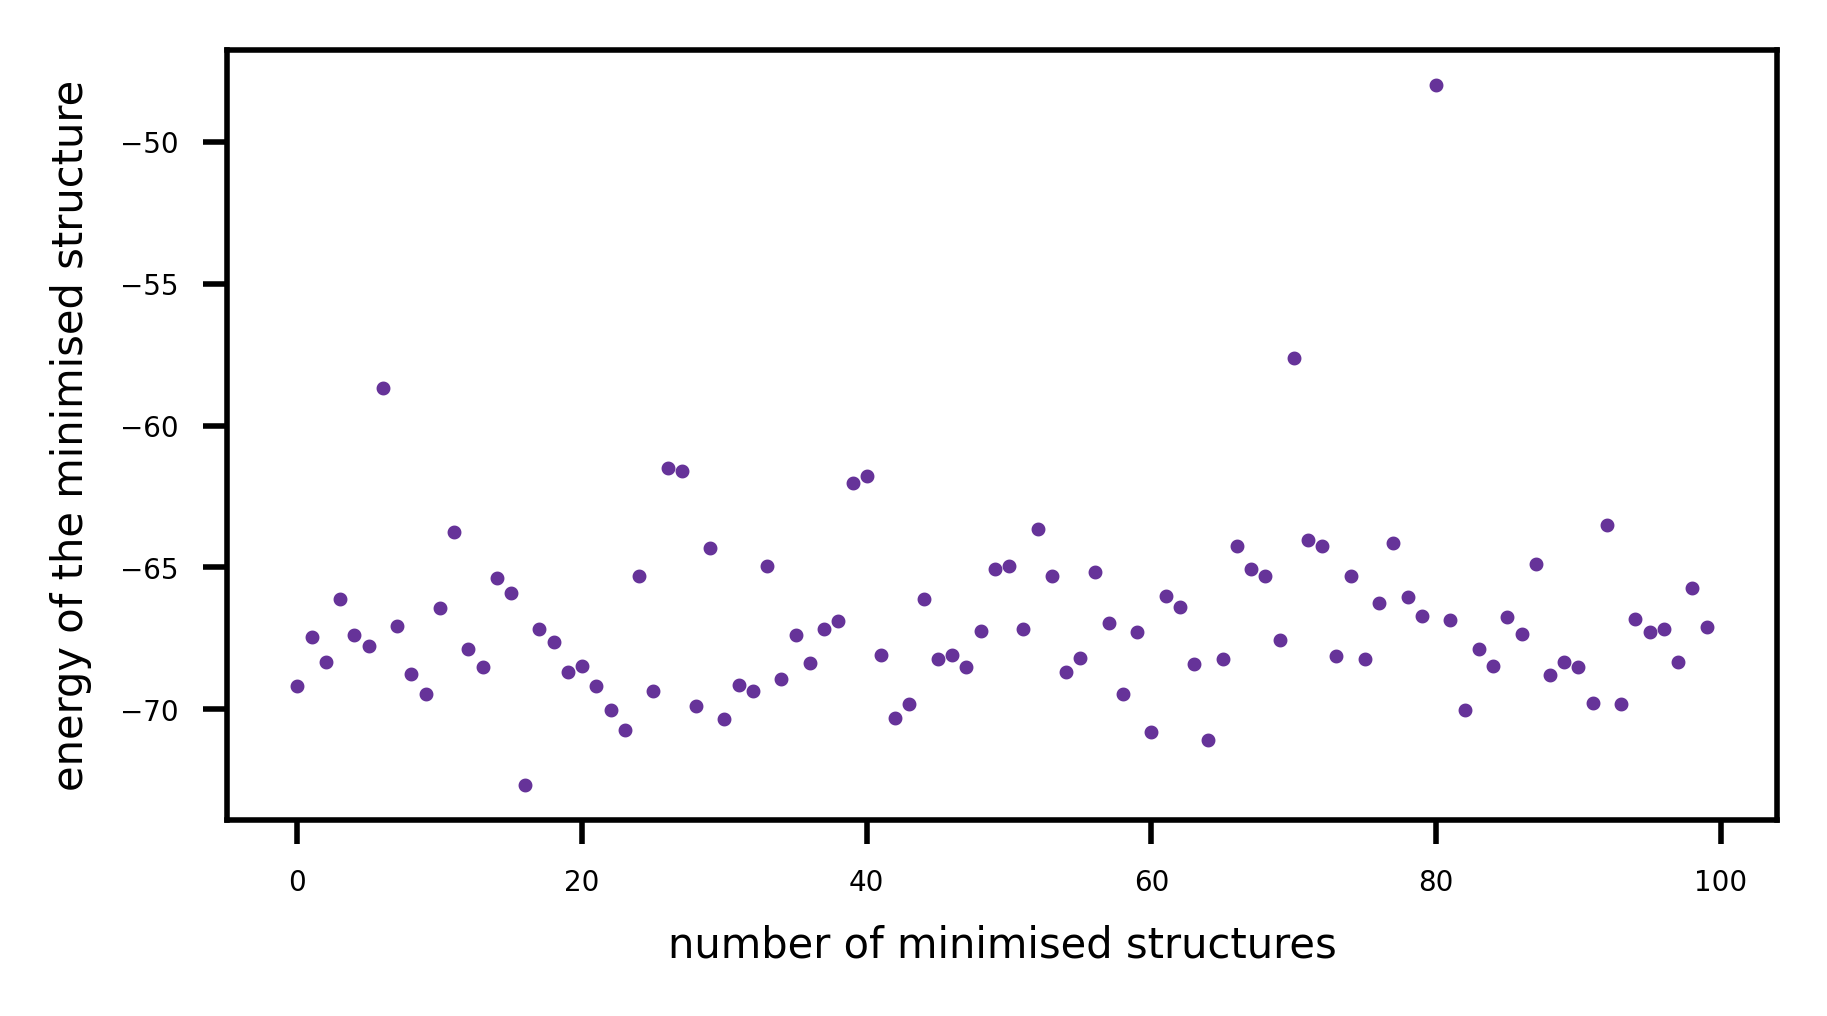

In [ ]:
fig=plt.figure(num=None,figsize=(4,2),dpi=500,facecolor='w',edgecolor='k')
plt.tick_params(axis='both', which='major', labelsize=4)
plt.xlabel('number of minimised structures',fontsize=6)
plt.ylabel('energy of the minimised structure',fontsize=6)
plt.scatter(np.arange(len(energies)),energies,color='rebeccapurple',s=1)
plt.savefig('LJ19_min.png')

## Step 5

Implementation of the basin hopping algorithm

In [229]:
def perturb_structure(atoms, method = 'wild', magnitude = 1.0):
    '''
    Pertubation Methods

    'wild' - randomly selects one atom and changes all of its coordinates randomly within a restricted
    box space (if it was moved randomly across the entire box space, it may move outside the cutoff of
    all atoms in the structure and effectively reduces the LJ19 cluster to an LJ18 cluster.), i.e. moves
    a random atom in a random directions by a random amount.

    'stretch' - calculates the centroid of the cluster, then moves all the atoms away from that centroid
    before performing the energy minimisation. Additional parameter can control how far away all of the
    atoms are moved.

    'sweep' - computes cluster centroid, moves the k-furthest atoms in a random directions by a random amount.
    Based on the idea that the core of the cluster is likely stable, but the outermost atoms are those that
    need to be displaced.

    'swap' - swap two random atoms coordinates. e.g. randomly swap the x coordinate of atom a with the x
    coordinate of atom b. OR randomly swap the y coordinate of atom a with the z coordinate of atom b
    '''

    if method == 'wild':
        atom_index = np.random.randint(len(atoms) - 1)
        box_length = atoms.cell[0][0]
        atoms.positions[atom_index] = np.random.uniform(box_length*0.25, box_length*0.75, size = 3)

    elif method == 'stretch':
        centroid = np.mean(atoms.positions, axis = 0)
        vectors = atoms.positions - centroid
        norms = np.linalg.norm(vectors, axis = 1)
        mask = norms > 0.0
        unit_vectors = vectors[mask]/norms[mask, None]

        lengths = np.random.uniform(low = 0.0, high = 3.0, size = (unit_vectors.shape[0], 1))
        atoms.positions += unit_vectors * lengths


    elif method == 'sweep':
        k = 3

        # Computing distance from centre of the cluster
        centroid = np.mean(atoms.positions, axis = 0)
        vectors = atoms.positions - centroid
        distances = np.linalg.norm(vectors, axis = 1)
        
        #identifying the k-furthest atoms from the centre of the cluster
        idx = np.argsort(distances)[-k:][::-1]

        rng = np.random.default_rng()
        directions = rng.normal(size = (len(idx), 3)) #randomising the directions each of the k-furthest atoms will be moved
        directions /= np.linalg.norm(directions, axis=1, keepdims = True) #normalising to produce the unit vector
        lengths = np.random.uniform(low = 0.0, high = 3.0, size = (directions.shape[0], 1)) #random magnitudes
        
        atoms.positions[idx] += directions * lengths
    
    elif method == 'swap':
        print(atoms.positions)
        rng = np.random.default_rng()
        
        #randomising the atoms selected to be swapped
        atom_a = rng.integers(0, n)
        atom_b = rng.integers(0, n)

        #randomising the x, y, z coordinate to be swapped
        comp_a = rng.integers(0, 3)
        comp_b = rng.integers(0, 3)

        atoms.positions[atom_a, comp_a], atoms.positions[atom_b, comp_b] = atoms.positions[atom_b, comp_b], atoms.positions[atom_a, comp_a]

    return atoms


In [230]:
n = 19 # number of LJ atoms
box_length = 12 # length of box side

energies = []
structures = []

for i in range(100):
    if i == 0:
        lj_19 = initialise_structure(n = n, box_length = box_length)
    else:
        lj_19 = perturb_structure(minimum, method = 'swap')

    minimise_structure(lj_19, id = i)

    energy = lj_19.get_potential_energy()
    energies.append(energy)
    structures.append(lj_19)

    # minimum variable stores the structure with the lowest energy
    if energy == min(energies):
        minimum = lj_19 

      Step     Time          Energy          fmax
BFGS:    0 19:11:37      348.679272     5630.032633
BFGS:    1 19:11:37       30.132103      532.782156
BFGS:    2 19:11:37       -5.438676       25.288857
BFGS:    3 19:11:37       -6.248308        2.782841
BFGS:    4 19:11:37       -6.853352        3.204181
BFGS:    5 19:11:37       -3.282818      118.243404
BFGS:    6 19:11:37       -9.093673        3.598675
BFGS:    7 19:11:37       -5.366447       52.607603
BFGS:    8 19:11:37      -10.154292        3.804898
BFGS:    9 19:11:37      -10.926176        3.850469
BFGS:   10 19:11:37       -9.081325       29.219865
BFGS:   11 19:11:37      -11.374253        4.118912
BFGS:   12 19:11:37      -11.736788        3.588935
BFGS:   13 19:11:37       38.835247      880.261120
BFGS:   14 19:11:37      -11.929889        3.383278
BFGS:   15 19:11:37      -12.091289        3.178768
BFGS:   16 19:11:37      -12.209585       10.167040
BFGS:   17 19:11:37      -12.369367        2.987746
BFGS:   18 19:

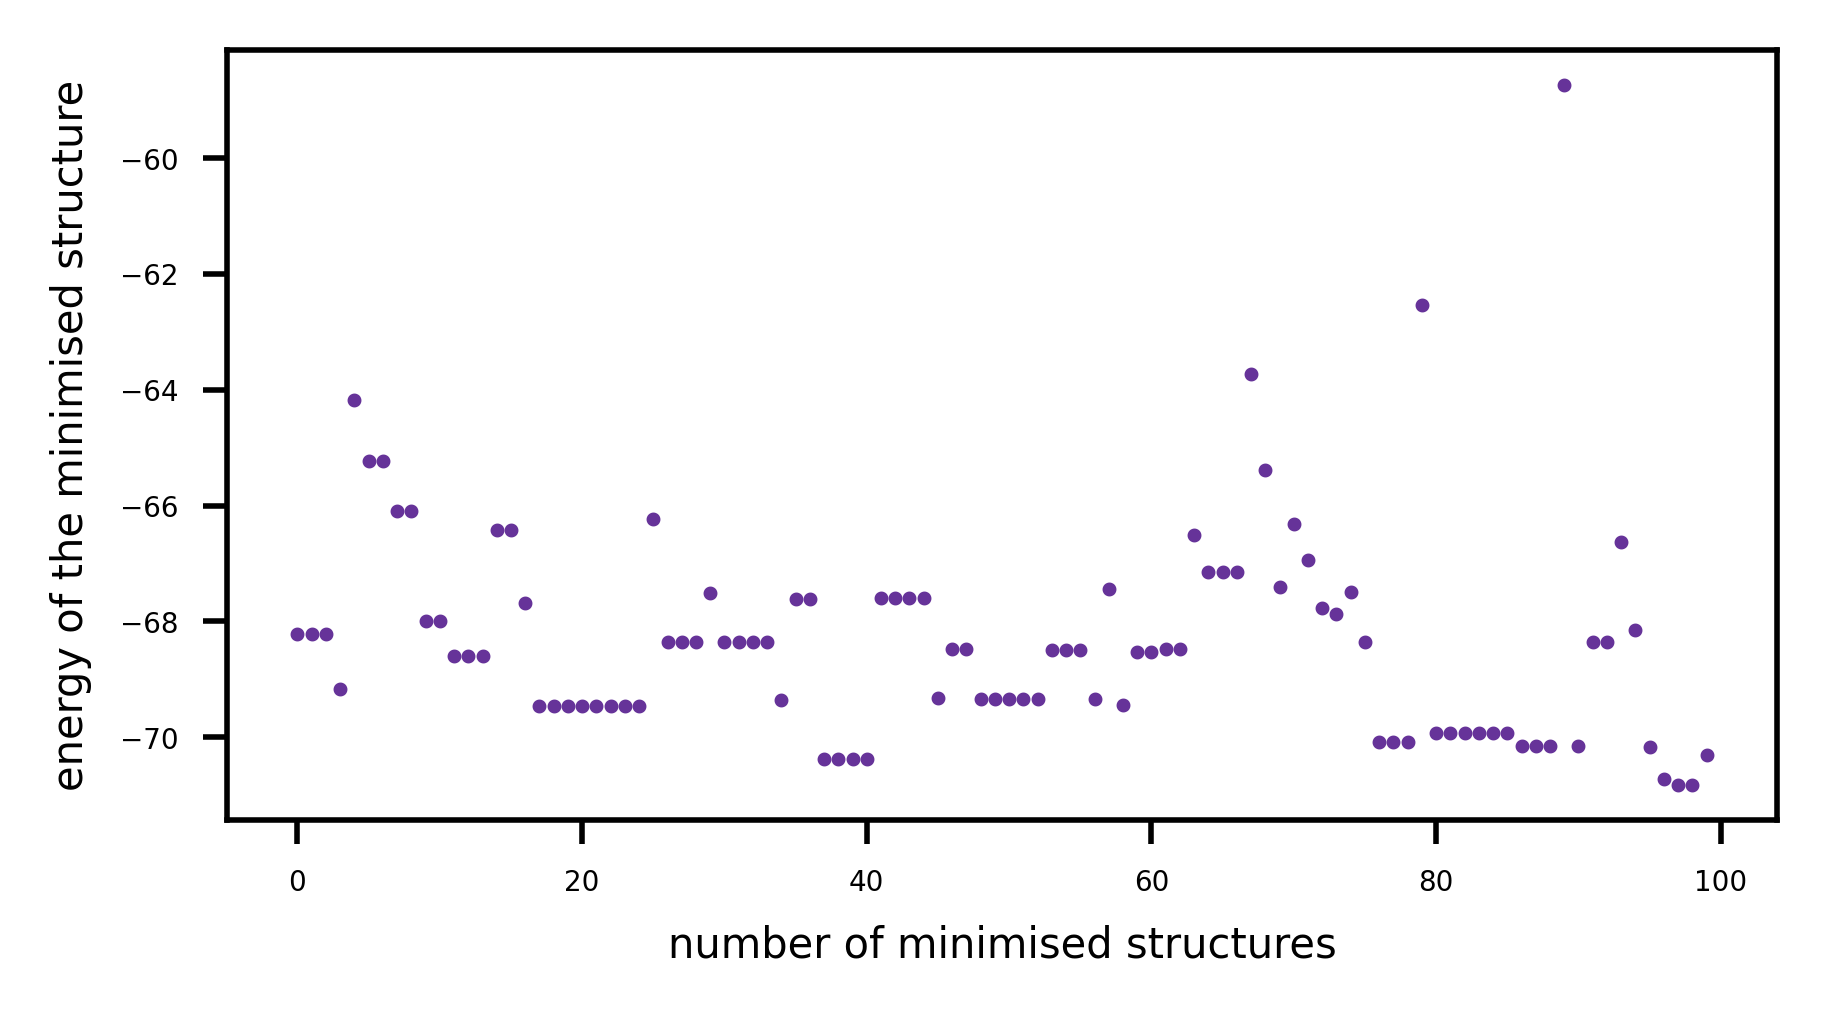

In [231]:
fig=plt.figure(num=None,figsize=(4,2),dpi=500,facecolor='w',edgecolor='k')
plt.tick_params(axis='both', which='major', labelsize=4)
plt.xlabel('number of minimised structures',fontsize=6)
plt.ylabel('energy of the minimised structure',fontsize=6)
plt.scatter(np.arange(len(energies)),energies,color='rebeccapurple',s=1)
plt.savefig('LJ19_min.png')

### Analysis of Pertubation Methods
#### 'Wild'

#### 'Stretch'

#### 'Sweep'

#### 'Swap'